# Housing Loan Prediction 

In [114]:
import boto3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from time import gmtime, strftime
import urllib.request, json, os, sagemaker
from sagemaker import get_execution_role
from time import gmtime, strftime
from sagemaker.predictor import csv_serializer
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

In [115]:
my_region = boto3.session.Session().region_name
prefix = 'sagemaker/MLI-Lab_solution'

print("Region: {}".format(my_region))

Region: us-east-1


In [116]:
s3 = boto3.resource('s3')
bucket_name = 'finalproject22a'

In [117]:
try:
    if  my_region == 'us-east-1':
        if not s3.Bucket(bucket_name).creation_date:
            s3.create_bucket(Bucket=bucket_name)
            print('S3 bucket created successfully')
        else:
            print('Bucket already exists!')
    else: 
        if not s3.Bucket(bucket_name).creation_date:
            s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={'LocationConstraint': my_region})
            print('S3 bucket created successfully')
        else:
            print('Bucket already exists!')
except Exception as e:
    print('S3 error: ', e)

Bucket already exists!


In [132]:
import os

DATASET_Train= 'loan_train.csv'
DATASET_Test = 'loan_test.csv'
DATA_FOLDER = 's3://finalproject22a/archive'
df = pd.read_csv(os.path.join(DATA_FOLDER, DATASET_Train))
df_test = pd.read_csv(os.path.join(DATA_FOLDER, DATASET_Test))
df_copy = df.copy()

In [6]:
#df_train = pd.read_csv(os.path.join(DATA_FOLDER, DATASET_Train))

# EDA

In [7]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area,Status
0,Male,No,0,Graduate,No,584900,0.0,15000000,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,458300,150800.0,12800000,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,300000,0.0,6600000,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,258300,235800.0,12000000,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,600000,0.0,14100000,360.0,1.0,Urban,Y


In [8]:
df.shape

(614, 12)

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Applicant_Income,614.0,5.403459e+05,6.109042e+05,15000.0,287750.0,381250.0,579500.0,8100000.0
Coapplicant_Income,614.0,1.621246e+05,2.926248e+05,0.0,0.0,118850.0,229725.0,4166700.0
Loan_Amount,614.0,1.414104e+07,8.815682e+06,0.0,9800000.0,12500000.0,16475000.0,70000000.0
Term,600.0,3.420000e+02,6.512041e+01,12.0,360.0,360.0,360.0,480.0
Credit_History,564.0,8.421986e-01,3.648783e-01,0.0,1.0,1.0,1.0,1.0


In [56]:
df[df['Loan_Amount']==0]

,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area,Status
35,Male,Yes,0,Graduate,No,227500,206700.0,0,360.0,1.0,Urban,Y
63,Male,Yes,1,Graduate,No,494500,0.0,0,360.0,0.0,Rural,N
81,Male,Yes,1,Graduate,Yes,239500,0.0,0,360.0,1.0,Semiurban,Y
103,Male,Yes,0,Graduate,No,465200,358300.0,0,360.0,1.0,Semiurban,Y
113,Female,No,1,Graduate,Yes,745100,0.0,0,360.0,1.0,Semiurban,Y
127,Male,No,0,Graduate,No,386500,164000.0,0,360.0,1.0,Rural,Y
202,Male,Yes,3+,Not Graduate,No,399200,0.0,0,180.0,1.0,Urban,N
284,Male,Yes,0,Graduate,No,2066700,0.0,0,360.0,1.0,Rural,N
305,Male,No,0,Not Graduate,No,200000,0.0,0,360.0,1.0,Urban,N
322,Male,Yes,2,Not Graduate,No,360100,159000.0,0,360.0,1.0,Rural,Y


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Gender              601 non-null    object 
 1   Married             611 non-null    object 
 2   Dependents          599 non-null    object 
 3   Education           614 non-null    object 
 4   Self_Employed       582 non-null    object 
 5   Applicant_Income    614 non-null    int64  
 6   Coapplicant_Income  614 non-null    float64
 7   Loan_Amount         614 non-null    int64  
 8   Term                600 non-null    float64
 9   Credit_History      564 non-null    float64
 10  Area                614 non-null    object 
 11  Status              614 non-null    object 
dtypes: float64(3), int64(2), object(7)
memory usage: 57.7+ KB


There are some missing values 

In [11]:
df = df.dropna()

In [12]:
df.shape

(499, 12)

In [188]:
df['Status'].value_counts()

Y    341
N    158
Name: Status, dtype: int64

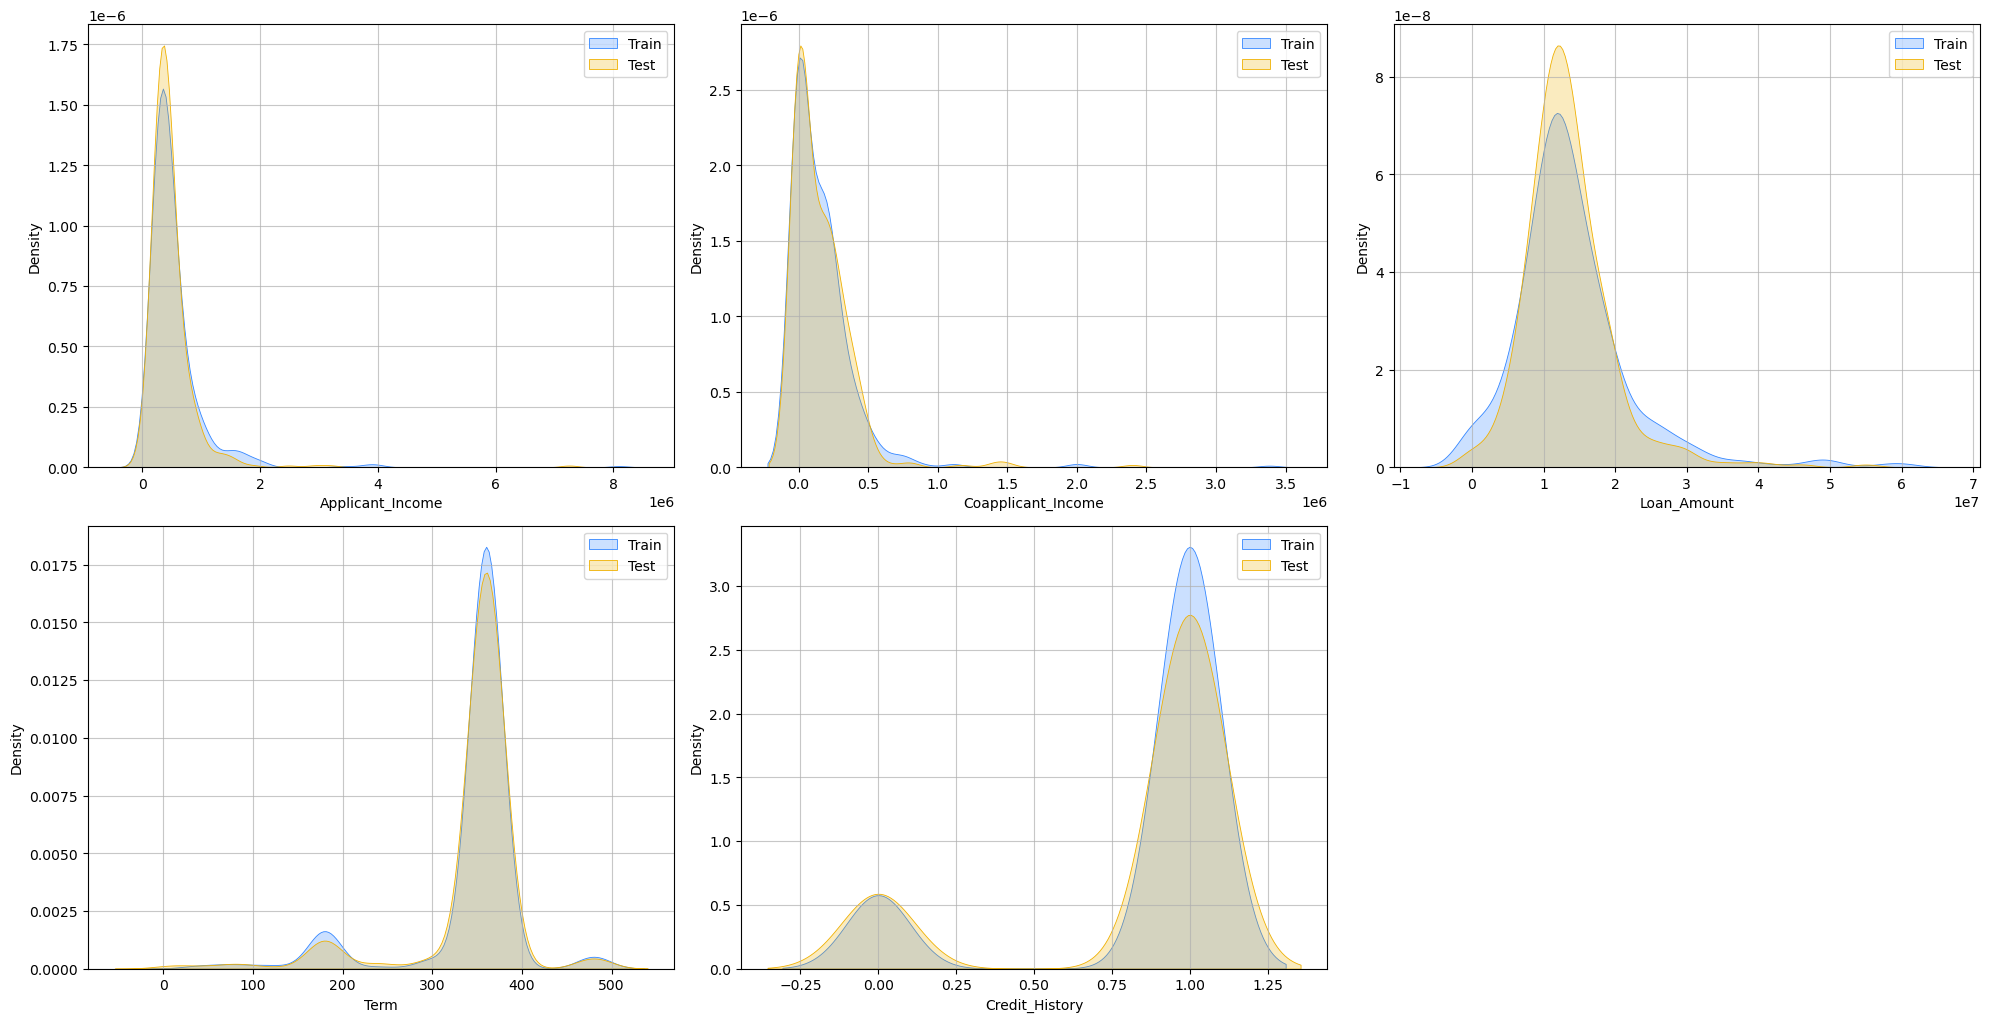

In [14]:
raw_train = df
raw_test = df_test
numeric_columns = list(df.describe().columns)

fig = plt.figure(figsize=(20, 50))
rows, cols = 10, 3
for idx, num in enumerate(numeric_columns[:30]):
    ax = fig.add_subplot(rows, cols, idx+1)
    ax.grid(alpha = 0.7, axis ="both")
    sns.kdeplot(x = num, fill = True,color ="#3386FF",linewidth=0.6, data = raw_train, label = "Train")
    sns.kdeplot(x = num, fill = True,color ="#EFB000",linewidth=0.6, data = raw_test, label = "Test")      
    ax.set_xlabel(num)
    ax.legend()
fig.tight_layout()
fig.show()

## Correlation Matrix

In [119]:
corr = df.corr()
corr

/tmp/ipykernel_14345/2438084875.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History
Applicant_Income,1.000000,-0.116605,0.539615,-0.045306,-0.014715
Coapplicant_Income,-0.116605,1.000000,0.189237,-0.059878,-0.002056
Loan_Amount,0.539615,0.189237,1.000000,0.041403,-0.000863
Term,-0.045306,-0.059878,0.041403,1.000000,0.001470
Credit_History,-0.014715,-0.002056,-0.000863,0.001470,1.000000


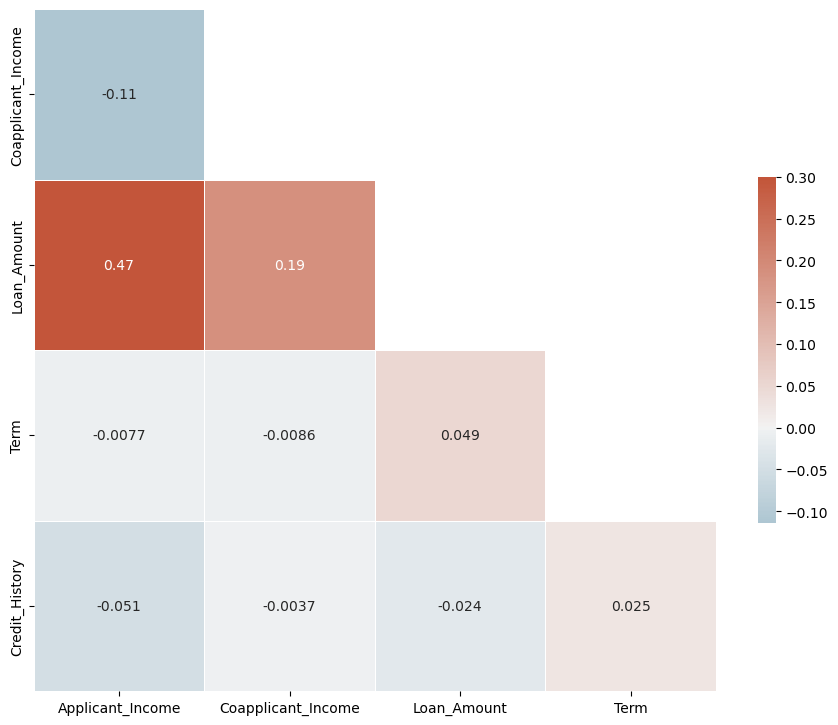

In [17]:
corr = df.corr(numeric_only = True)
mask = np.triu(np.ones_like(corr, dtype=bool))
mask = np.delete(mask, (0), axis=0)
mask = np.delete(mask, -1, axis=1)
mask
corr.drop(['Applicant_Income'], inplace = True)
corr.drop(['Credit_History'], axis = 1, inplace = True)
corr
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask = mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)
plt.show()

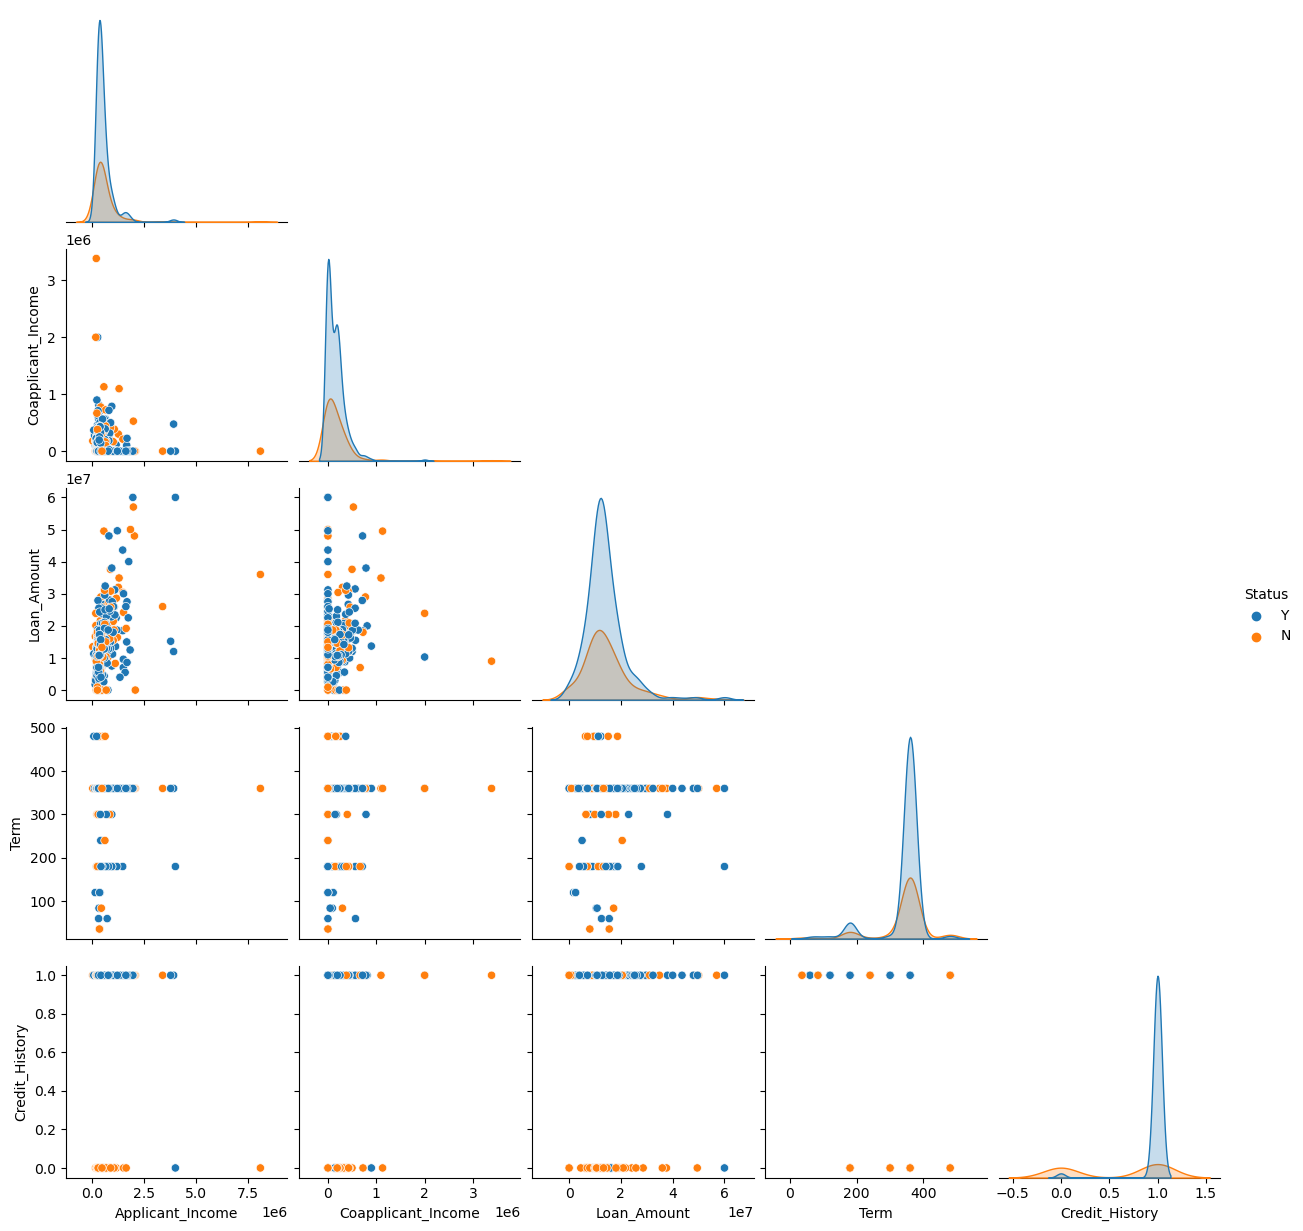

In [18]:
import seaborn as sns
sns.pairplot(df,corner=True,hue='Status');

## Numerical Variables

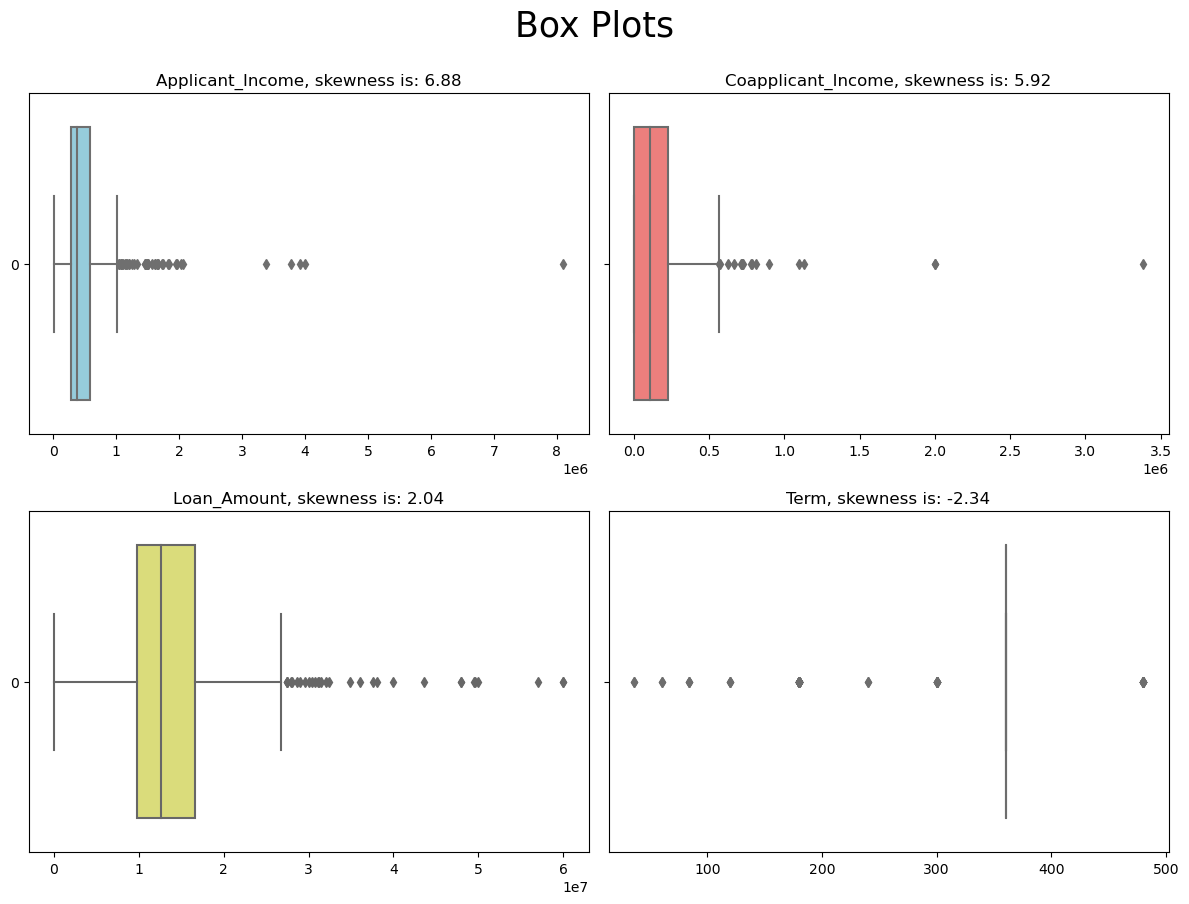

In [53]:
numeric_columns = list(df.describe().columns)
del numeric_columns[-1]
sns.set_palette("pastel")
col_code = ['#8BD3E6','#FF6D6A','#E9EC6B','#EFBE7D']
# checking boxplots
def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(12,9))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', ax=axs[i], color = col_code[i])
        axs[i].set_title(data + ', skewness is: '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))
        
boxplots_custom(dataset=df, columns_list=numeric_columns, rows=2, cols=2, suptitle='Box Plots')
plt.tight_layout()

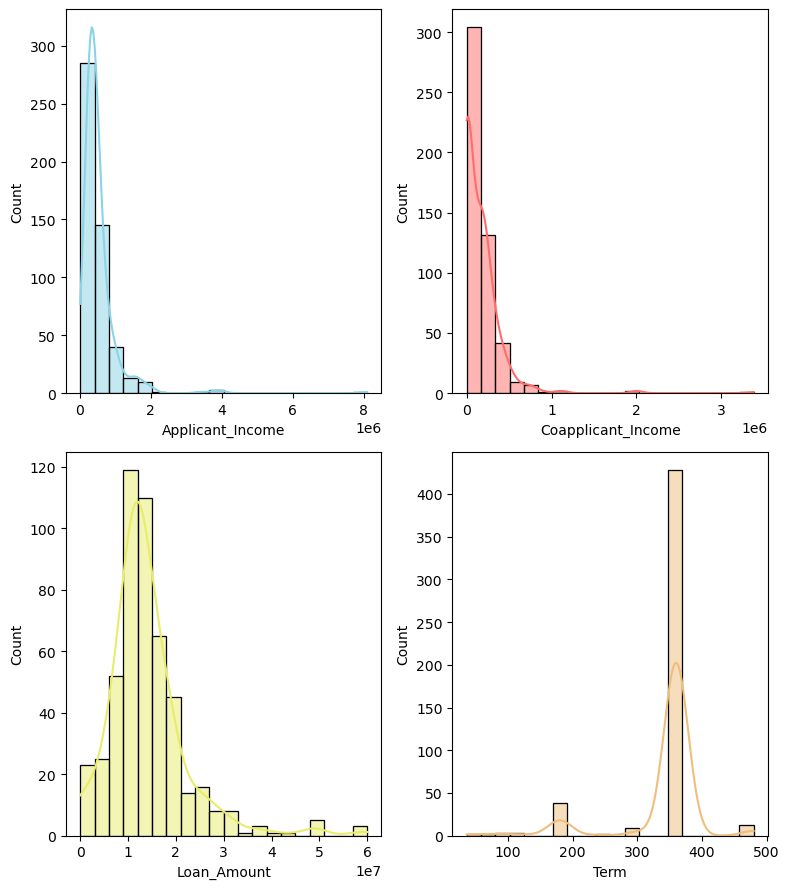

In [68]:
from matplotlib.ticker import NullFormatter
fig, axs = plt.subplots(2, 2, figsize = (8, 9))
c=1

for i, col in enumerate(numeric_columns):
    plt.subplot(2,2,c)
    sns.histplot(data = df[col], kde=True, bins=20, color = col_code[i])
    c = c+1
plt.tight_layout()

## Categorical Variable

In [21]:
cat_list = ['Gender','Married','Education','Area']

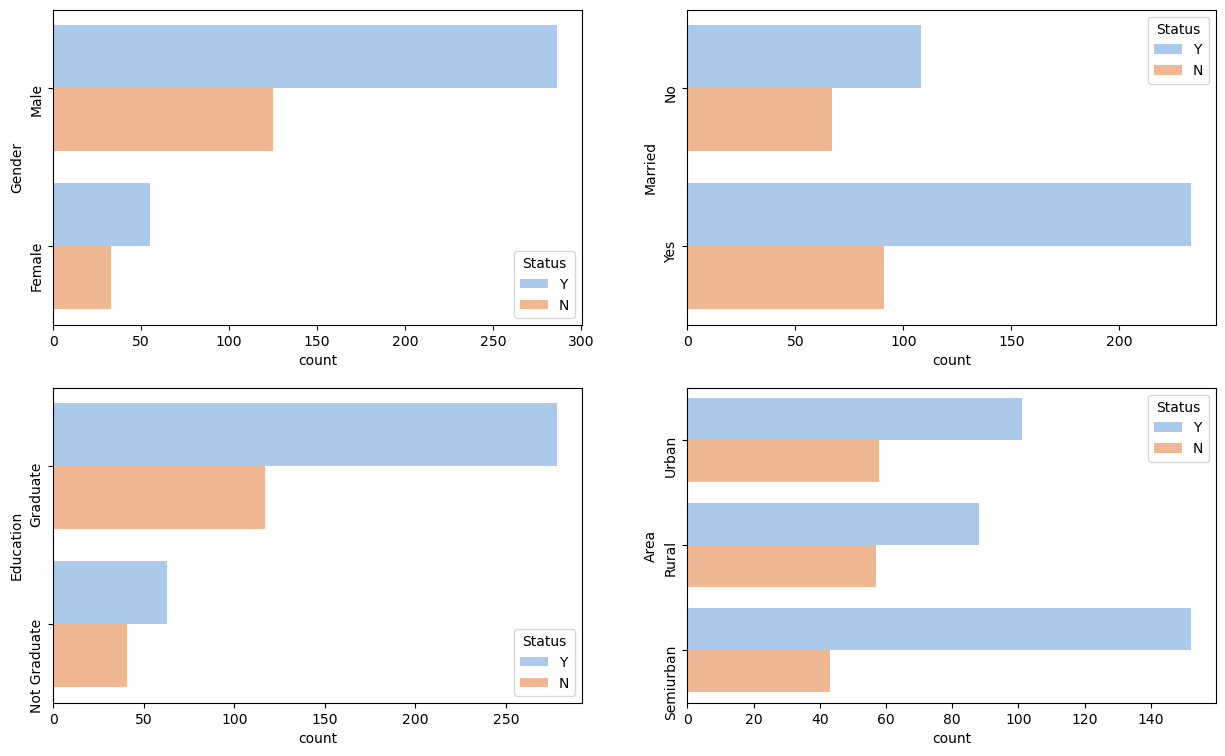

In [72]:
cat_list = ['Gender','Married','Education','Area']
fig, axs = plt.subplots(2, 2, figsize = (15, 9))
c=1
for col in cat_list:
    plt.subplot(2,2,c)
    g = sns.countplot(y=col,data=df,palette = 'pastel', hue='Status')
    plt.yticks(rotation=90)
    c = c+1

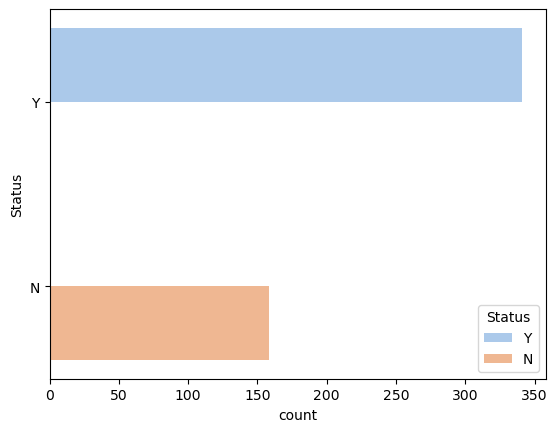

In [47]:
sns.countplot(y='Status',data=df, hue='Status')
plt.show()

## Preprocessing

In [121]:
from sklearn.preprocessing import LabelEncoder

for i in df.columns:
    if df[i].dtypes == 'O':
        df[i] =  LabelEncoder().fit_transform(df[i])

In [144]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area,Status
0,1,0,0,0,0,584900,0.0,15000000,360.0,1.0,2,1
1,1,1,1,0,0,458300,150800.0,12800000,360.0,1.0,0,0
2,1,1,0,0,1,300000,0.0,6600000,360.0,1.0,2,1
3,1,1,0,1,0,258300,235800.0,12000000,360.0,1.0,2,1
4,1,0,0,0,0,600000,0.0,14100000,360.0,1.0,2,1


In [122]:
corr = df.corr()
corr

,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area,Status
Gender,1.000000,0.336094,0.149674,0.024382,-0.025022,0.094472,0.073308,0.127268,-0.068536,-0.000515,-0.030903,0.008690
Married,0.336094,1.000000,0.338689,0.006759,-0.038153,0.052119,0.069877,0.126458,-0.097345,0.010690,0.007973,0.096657
Dependents,0.149674,0.338689,1.000000,0.060466,0.005622,0.103416,0.011146,0.109288,-0.074783,-0.079801,0.032600,-0.007318
Education,0.024382,0.006759,0.060466,1.000000,-0.021130,-0.140760,-0.062290,-0.175070,-0.078784,-0.081822,-0.065243,-0.085884
Self_Employed,-0.025022,-0.038153,0.005622,-0.021130,1.000000,0.095664,0.052218,0.085547,-0.037492,0.056894,-0.013439,0.010880
Applicant_Income,0.094472,0.052119,0.103416,-0.140760,0.095664,1.000000,-0.116605,0.539615,-0.045306,-0.014715,-0.009500,-0.004710
Coapplicant_Income,0.073308,0.069877,0.011146,-0.062290,0.052218,-0.116605,1.000000,0.189237,-0.059878,-0.002056,0.010522,-0.059187
Loan_Amount,0.127268,0.126458,0.109288,-0.175070,0.085547,0.539615,0.189237,1.000000,0.041403,-0.000863,-0.053658,-0.008782
Term,-0.068536,-0.097345,-0.074783,-0.078784,-0.037492,-0.045306,-0.059878,0.041403,1.000000,0.001470,-0.078748,-0.021268
Credit_History,-0.000515,0.010690,-0.079801,-0.081822,0.056894,-0.014715,-0.002056,-0.000863,0.001470,1.000000,-0.001969,0.561678


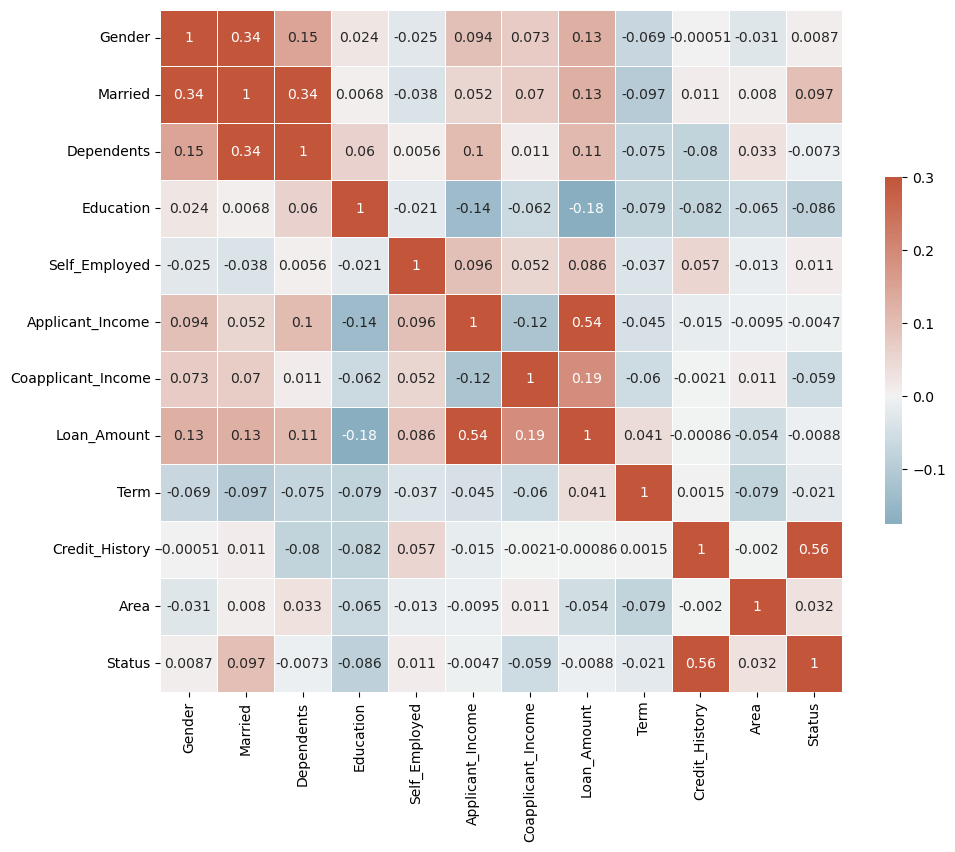

In [123]:
corr = df.corr(numeric_only = True)
mask = np.triu(np.ones_like(corr, dtype=bool))
mask = np.delete(mask, (0), axis=0)
mask = np.delete(mask, -1, axis=1)
mask
#corr.drop(['Applicant_Income'], inplace = True)
#corr.drop(['Credit_History'], axis = 1, inplace = True)
corr
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)
plt.show()

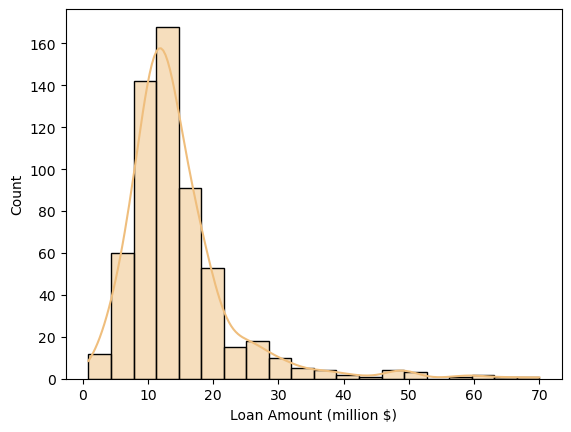

count    5.930000e+02
mean     1.464182e+07
std      8.551514e+06
min      9.000000e+05
25%      1.000000e+07
50%      1.280000e+07
75%      1.680000e+07
max      7.000000e+07
Name: Loan_Amount, dtype: float64

In [133]:
df2 = df_copy[df_copy['Loan_Amount'] != 0]
sns.histplot(data = df2['Loan_Amount']/1e6, kde=True, bins=20, color = '#EFBE7D')
plt.ticklabel_format(axis = 'x', useOffset=False, style='plain')
plt.xlabel('Loan Amount (million $)')
plt.show()

df2['Loan_Amount'].describe()

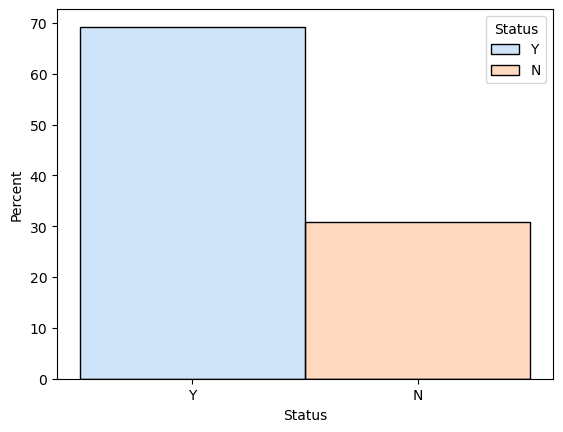

In [135]:
df2 = df_copy[df_copy['Loan_Amount'] != 0]
df2 = df2.dropna()
h = sns.histplot(data = df2, x='Status', stat='percent', bins=2, hue = 'Status')
plt.show()

In [136]:
df_copy[(df_copy['Applicant_Income'] < df_copy['Coapplicant_Income']) & (df_copy['Status'] == 'Y')].sort_values('Applicant_Income').T

,468,500,188,418,530,303,99,578,249,197,...,12,137,244,505,440,603,38,159,502,444
Gender,Female,Female,NaN,Male,Male,Male,Male,Male,Male,Female,...,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male
Married,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,...,Yes,Yes,Yes,Yes,No,No,No,Yes,Yes,Yes
Dependents,2,0,0,0,0,1,0,1,0,0,...,2,2,0,2,0,0,0,0,2,0
Education,Not Graduate,Graduate,Graduate,Graduate,Graduate,Graduate,Graduate,Graduate,Graduate,Not Graduate,...,Graduate,Graduate,Not Graduate,Graduate,Graduate,Graduate,Graduate,Graduate,Graduate,Graduate
Self_Employed,NaN,No,Yes,No,No,No,No,No,No,No,...,No,Yes,No,No,No,No,No,No,No,No
Applicant_Income,21000,64500,67400,102500,102500,162500,175900,178200,180900,190700,...,307300,331600,340600,351000,366000,367600,416600,458300,486500,733300
Coapplicant_Income,291700.0,368300.0,529600.0,277300.0,550000.0,180300.0,354100.0,223200.0,186800.0,236500.0,...,810600.0,350000.0,441700.0,441600.0,506400.0,430100.0,721000.0,562500.0,562400.0,833300.0
Loan_Amount,9800000,11300000,16800000,11200000,21600000,9600000,13100000,10700000,9000000,12000000,...,20000000,8800000,12300000,24300000,18700000,17200000,18400000,25500000,20800000,17500000
Term,360.0,480.0,360.0,360.0,360.0,360.0,360.0,360.0,360.0,NaN,...,360.0,360.0,360.0,360.0,360.0,360.0,360.0,360.0,360.0,300.0
Credit_History,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
